In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
import random 
import os 
import pickle 
import string
import requests
import collections 
import io
import tarfile
import urllib.request
from nltk.corpus import stopwords
sess = tf.Session()
%matplotlib inline

In [2]:
data_folder_name = 'temp'
if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)

In [3]:
#Declare model parameters 
batch_size = 200
embedding_size = 50
vocabulary_size = 2000
generations = 50000
model_learning_rate = 0.05
num_sampled = int(batch_size/2)
window_size = 3
#Add checkpoints t training 
save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 1000
#Declare stop words
stops = stopwords.words('english')
#We pick some test words. We are expecting synonyms to appear
valid_words = ['love', 'hate', 'happy', 'sad', 'man']

In [4]:
#Next we declare our data loading function, which checks to make sure we have not downloaded the data before it downloads,
#or it will load the data from the disk if we have saved it before
def load_movie_data():
    save_folder_name = 'rt-polaritydata'
    pos_file = os.path.join(save_folder_name, 'rt-polaritydata', 'rt-polarity.pos')
    neg_file = os.path.join(save_folder_name, 'rt-polaritydata', 'rt-polarity.neg')

    # Check if files are already downloaded
    if not os.path.exists(os.path.join(save_folder_name, 'rt-polaritydata')):
        movie_data_url = 'http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz'

        # Save tar.gz file
        req = requests.get(movie_data_url, stream=True)
        with open(os.path.join(save_folder_name,'temp_movie_review_temp.tar.gz'), 'wb') as f:
            for chunk in req.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    f.flush()
        # Extract tar.gz file into temp folder
        tar = tarfile.open(os.path.join(save_folder_name,'temp_movie_review_temp.tar.gz'), "r:gz")
        tar.extractall(path='temp')
        tar.close()

    pos_data = []
    with open(pos_file, 'r', encoding='latin-1') as f:
        for line in f:
            pos_data.append(line.encode('ascii',errors='ignore').decode())
    f.close()
    pos_data = [x.rstrip() for x in pos_data]

    neg_data = []
    with open(neg_file, 'r', encoding='latin-1') as f:
        for line in f:
            neg_data.append(line.encode('ascii',errors='ignore').decode())
    f.close()
    neg_data = [x.rstrip() for x in neg_data]
    
    texts = pos_data + neg_data
    target = [1]*len(pos_data) + [0]*len(neg_data)
    
    return(texts, target)

In [5]:
#Now we crate a normalization function for text. This function will input a list of strings and apply lowecasing, remove
#punctiation, remove numbers, trim extra whitespace, and remove stop words. 
def normalize_text(texts, stops):
    #Lower case
    texts = [x.lower() for x in texts]
    #Remove punctuation
    texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
    #Remove numbers
    texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
    #Remove stopwords
    texts = [' '.join(word for word in x.split() if word not in (stops)) for x in texts]
    #Trim extra whitespace
    texts = [' '.join(x.split()) for x in texts]
    
    return(texts)

In [6]:
# Declare stop words
stops = stopwords.words('english')

# We pick some test words. We are expecting synonyms to appear
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']
# Later we will have to transform these into indices

# Load the movie review data
print('Loading Data')
texts, target = load_movie_data()

# Normalize text
print('Normalizing Text Data')
texts = normalize_text(texts, stops)

# Texts must contain at least 3 words
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > 2]
texts = [x for x in texts if len(x.split()) > 2]
print('Done.')

Loading Data
Normalizing Text Data
Done.


In [7]:
#To build our vocabulary, we create a function that creates a dictionary of words with their count, and any word that is
#uncommon enough to not make our vocabulary size cut-off, we label as 'RARE'
def build_dictionary(sentences, vocabulary_size):
    #Turn sentences (list of strings) into lists of words
    split_sentences = [s.split() for s in sentences]
    words = [x for sublist in split_sentences for x in sublist]
    #Initialize list of [word, word_count] for each word, starting with unknown
    count = [['RARE', -1]]
    #Now add most frequent words, limited to the N-most frequent(N=vocabulary size)
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    #Now create the dictionary
    word_dict = {}
    #For each word, that we want in the dictionary, add it, then make it the value of the prior dictionary length
    for word, word_count in count:
        word_dict[word] = len(word_dict)
    return(word_dict)

In [8]:
#We need a function that will convert a list of sentences into lists of word indices that we can pass into our embedding 
#lookup function
def text_to_numbers(sentences, word_dict):
    #Initialize the returned data 
    data = []
    for sentence in sentences:
        sentence_data = []
        #For each word, either use selected index or rare word index
        for word in sentence:
            if word in word_dict:
                word_ix = word_dict[word]
            else:
                word_ix = 0
            sentence_data.append(word_ix)
        data.append(sentence_data)
    return(data)

In [9]:
# Build our data set and dictionaries
print('Creating Dictionary')
word_dictionary = build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_to_numbers(texts, word_dictionary)

# Get validation word keys
valid_examples = [word_dictionary[x] for x in valid_words]

Creating Dictionary


In [10]:
#We now create a function that will return our skip-gram batches. We want to train on pairs of words where one word
#is the training input (from the target word at the center of our window) and the other word is selected from the 
#window. For example, the sentence "the cat in the hat" may result in (input,output) pairs such as the following:
#(the,in), (cat,in), (the,in), (hat,in), if in was the target word, and we had a window size of two in each direction
def generate_batch_data(sentences, batch_size, window_size, method='skip_gram'):
    # Fill up data batch
    batch_data = []
    label_data = []
    while len(batch_data) < batch_size:
        # select random sentence to start
        rand_sentence_ix = int(np.random.choice(len(sentences), size=1))
        rand_sentence = sentences[rand_sentence_ix]
        # Generate consecutive windows to look at
        window_sequences = [rand_sentence[max((ix-window_size),0):(ix+window_size+1)] for ix, x in enumerate(rand_sentence)]
        # Denote which element of each window is the center word of interest
        label_indices = [ix if ix<window_size else window_size for ix,x in enumerate(window_sequences)]
        
        # Pull out center word of interest for each window and create a tuple for each window
        if method=='skip_gram':
            batch_and_labels = [(x[y], x[:y] + x[(y+1):]) for x,y in zip(window_sequences, label_indices)]
            # Make it in to a big list of tuples (target word, surrounding word)
            tuple_data = [(x, y_) for x,y in batch_and_labels for y_ in y]
            batch, labels = [list(x) for x in zip(*tuple_data)]
        elif method=='cbow':
            batch_and_labels = [(x[:y] + x[(y+1):], x[y]) for x,y in zip(window_sequences, label_indices)]
            # Only keep windows with consistent 2*window_size
            batch_and_labels = [(x,y) for x,y in batch_and_labels if len(x)==2*window_size]
            batch, labels = [list(x) for x in zip(*batch_and_labels)]
        elif method=='doc2vec':
            # For doc2vec we keep LHS window only to predict target word
            batch_and_labels = [(rand_sentence[i:i+window_size], rand_sentence[i+window_size]) for i in range(0, len(rand_sentence)-window_size)]
            batch, labels = [list(x) for x in zip(*batch_and_labels)]
            # Add document index to batch!! Remember that we must extract the last index in batch for the doc-index
            batch = [x + [rand_sentence_ix] for x in batch]
        else:
            raise ValueError('Method {} not implemented yet.'.format(method))
            
        # extract batch and labels
        batch_data.extend(batch[:batch_size])
        label_data.extend(labels[:batch_size])
    # Trim batch and label at the end
    batch_data = batch_data[:batch_size]
    label_data = label_data[:batch_size]
    
    # Convert to numpy array
    batch_data = np.array(batch_data)
    label_data = np.transpose(np.array([label_data]))
    
    return(batch_data, label_data)

In [11]:
print('Creating Model')
# Define Embeddings:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# NCE loss parameters
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                               stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Create data/target placeholders
x_inputs = tf.placeholder(tf.int32, shape=[batch_size, 2*window_size])
y_target = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Lookup the word embedding
# Add together window embeddings:
embed = tf.zeros([batch_size, embedding_size])
for element in range(2*window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])

Creating Model


In [12]:
#We use the NCE loss function that TensorFlow has built in because categorical output is too sparse for the softmax to
#converge, as follows

# Get loss from prediction
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                     biases=nce_biases,
                                     labels=y_target,
                                     inputs=embed,
                                     num_sampled=num_sampled,
                                     num_classes=vocabulary_size))

# Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate).minimize(loss)

# Cosine similarity between words
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [13]:
#To save our embeddings, we must load the TensorFlow train.Saver method. This method defaults to saving the whole graph,
#but we can give it an argument just to save the embedding variable, and we can also give it a specific name. Here we give
#it the same name as the variable name in our graph
saver = tf.train.Saver({"embeddings":embeddings})

In [14]:
#We now declare an optimizer function and initialize our model variables.
init = tf.global_variables_initializer()
sess.run(init)

In [15]:
# Filter out sentences that aren't long enough:
text_data = [x for x in text_data if len(x)>=(2*window_size+1)]

In [16]:
#Finally, we can loop across our training step and print out the loss, and save the embeddings and dictionary when we 
#specify:
#Now we can print our embeddings and print off the loss and closest words to our validations set during the training.
print('Starting Training')
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = generate_batch_data(text_data, batch_size,
                                                                  window_size, method='cbow')
    feed_dict = {x_inputs : batch_inputs, y_target : batch_labels}

    # Run the train step
    sess.run(optimizer, feed_dict=feed_dict)

    # Return the loss
    if (i+1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print('Loss at step {} : {}'.format(i+1, loss_val))
      
    # Validation: Print some random words and top 5 related words
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},' .format(log_str, close_word)
            print(log_str)
            
    # Save dictionary + embeddings
    if (i+1) % save_embeddings_every == 0:
        # Save vocabulary dictionary
        with open(os.path.join(data_folder_name,'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        
        # Save embeddings
        model_checkpoint_path = os.path.join(os.getcwd(),data_folder_name,'cbow_movie_embeddings.ckpt')
        save_path = saver.save(sess, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))

Starting Training
Loss at step 1000 : 3.1904115676879883
Loss at step 2000 : 2.7858283519744873
Loss at step 3000 : 2.5651252269744873
Loss at step 4000 : 2.2575652599334717
Loss at step 5000 : 2.155435562133789
Nearest to love: ludicrous, lee, pleasant, format, smug,
Nearest to hate: lazy, storytelling, cultural, wouldnt, big,
Nearest to happy: anyway, toward, balance, robert, visually,
Nearest to sad: memories, hits, got, simply, science,
Nearest to man: way, played, making, guys, spectacular,
Nearest to woman: importance, cinema, poor, harmless, material,
Model saved in file: /home/huzeyfekiran/Downloads/Cookbook exercises/temp/cbow_movie_embeddings.ckpt
Loss at step 6000 : 4.902319431304932
Loss at step 7000 : 1.8063534498214722
Loss at step 8000 : 1.8216465711593628
Loss at step 9000 : 1.8166290521621704
Loss at step 10000 : 1.774012804031372
Nearest to love: ludicrous, lee, pleasant, format, smug,
Nearest to hate: lazy, storytelling, cultural, wouldnt, big,
Nearest to happy: anyw

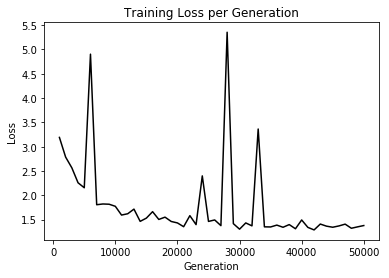

In [17]:
# Plot loss over time
plt.plot(loss_x_vec, loss_vec, 'k-')
plt.title('Training Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()